In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')

import seaborn as sns
color = sns.color_palette()
sns.set(rc={'figure.figsize':(25,15)})

import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go

import plotly.figure_factory as ff


import warnings
warnings.filterwarnings('ignore')

# Primeiros Passos

- Este Dataset foi disponibilizado no site Kaggle e consiste em informações sobre apps, tais como: Categoria, Avaliações, número de instalações etc

In [3]:
df = pd.read_csv('./input/googleplaystore.csv')
df_review = pd.read_csv('./input/googleplaystore_user_reviews.csv')

In [4]:
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


## Limpando o Dataset

In [5]:
#Eliminando Apps duplicados
df.drop_duplicates(subset='App', inplace=True)
#Eliminando alguns NaN e valores não desejados
df = df[df['Android Ver'] != np.nan]
df = df[df['Android Ver'] != 'NaN']
df = df[df['Installs'] != 'Free']
df = df[df['Installs'] != 'Paid']

- Agora vou transformar todos os itens da coluna Size para MB
- Retirar todos os simbolos ('+', '$', etc)
- Transformar os valores para numérico

In [6]:
df['Installs'] = df['Installs'].apply(lambda x:re.sub(r'[^(0-9)\s]', '', x))
df['Installs'] = pd.to_numeric(df['Installs'])
df['Size'] = df['Size'].apply(lambda x: str(x).replace('Varies with device', 'NaN') if 'Varies with device' in str(x) else x)
df['Size'] = df['Size'].apply (lambda x: re.sub(r'M', '', x) if 'M' in str(x) else x)
df['Size'] = df['Size'].apply (lambda x: re.sub(r',', '', x) if 'M' in str(x) else x)
df['Size'] = df['Size'].apply (lambda x: float(re.sub(r'k', '', x))/1000 if 'k' in str(x) else x )
df['Size'] = df['Size'].apply(lambda x: float(x))
df['Price'] = df['Price'].apply (lambda x: x.replace(r'$', '') if '$' in str(x) else x)
df['Price'] = pd.to_numeric(df['Price'])
df['Reviews'] = pd.to_numeric(df['Reviews'])

# Visualizando

### Número de Apps por categoria

Text(0.5, 1.0, 'Apps')

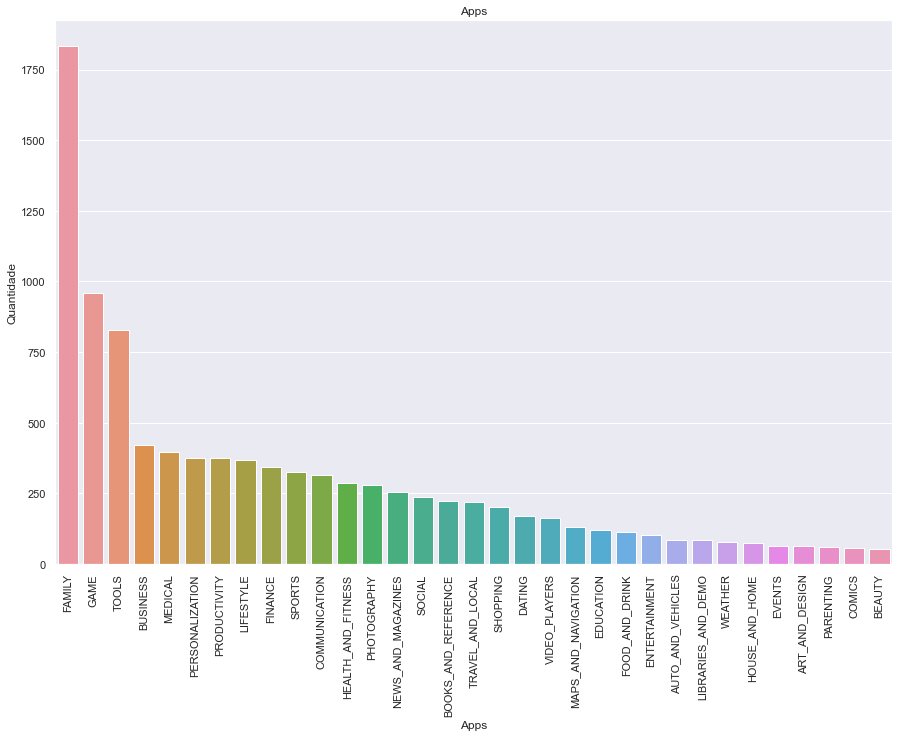

In [8]:
numero_de_apps_categoria = df['Category'].value_counts().sort_values(ascending=False)

#Visualização
plt.figure(figsize=(15,10))
sns.barplot(x=numero_de_apps_categoria.index, y=numero_de_apps_categoria.values)
plt.xticks(rotation= 90)
plt.xlabel('Apps')
plt.ylabel('Quantidade')
plt.title('Apps')

- 'Family', 'Game' e 'Tools' foram as categorias com maior número de downloads

## Distribuição das avaliações

Média de Avaliações =  4.173243045387994


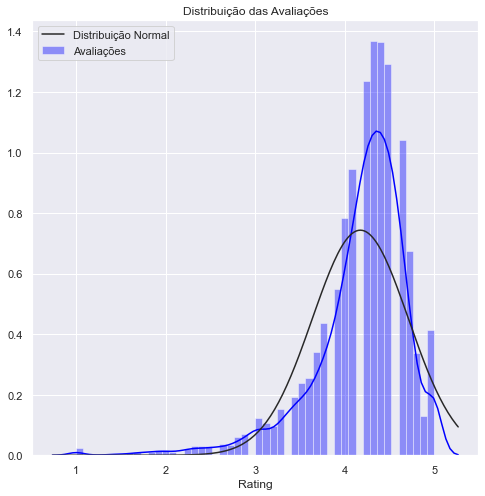

In [9]:
print('Média de Avaliações = ', np.mean(df['Rating']))
plt.figure(figsize=(8,8))
plt.title('Distribuição das Avaliações')
sns.distplot(df['Rating'],kde=True,color='blue',fit=stats.norm)
plt.legend(['Distribuição Normal','Avaliações',])

## Categorias mais bem sucedidas

In [10]:
grupos = df.groupby('Category').filter(lambda x: len(x) >= 170).reset_index()
print('Média de Avaliações = ', np.nanmean(list(grupos.Rating)))

Média de Avaliações =  4.170026786973072


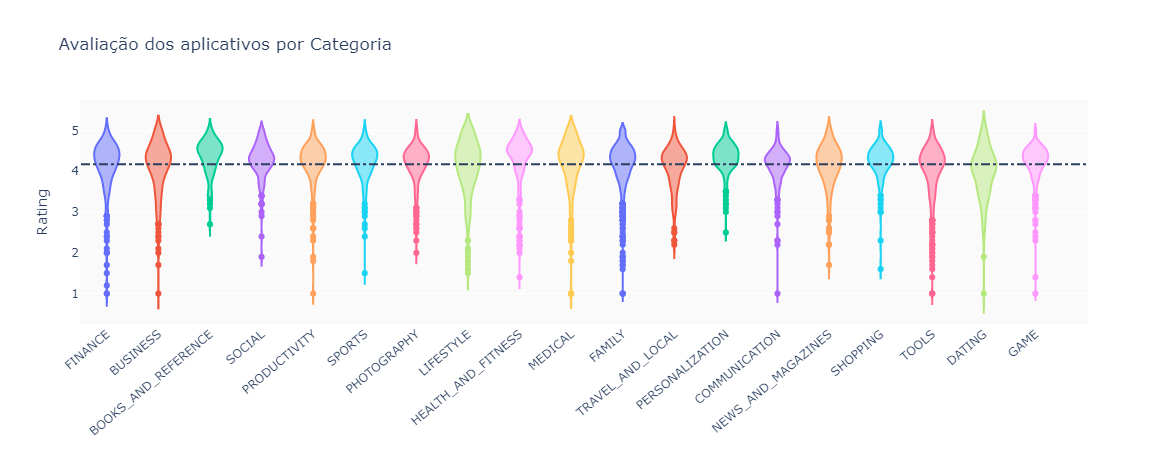

In [11]:
layout = {'title' : 'Avaliação dos aplicativos por Categoria',
        'xaxis': {'tickangle':-40},
        'yaxis': {'title': 'Rating'},
          'plot_bgcolor': 'rgb(250,250,250)',
          'shapes': [{
              'type' :'line',
              'x0': -.5,
              'y0': np.nanmean(list(grupos.Rating)),
              'x1': 19,
              'y1': np.nanmean(list(grupos.Rating)),
              'line': { 'dash': 'dashdot'}
          }]
          }

data = [{
    'y': df.loc[df.Category==category]['Rating'], 
    'type':'violin',
    'name' : category,
    'showlegend':False,
    #'marker': {'color': 'Set2'},
    } for i,category in enumerate(list(set(grupos.Category)))]



plotly.offline.iplot({'data': data, 'layout': layout})

- Praticamente todas as categorias tiveram um bom desempenho
- 'Health and Fitness' e 'Books and Reference tiveram' uma média de 4.5!
- 'Dating' nao obteve um bom desempenho. 50% dos Apps estiveram abaixo da média de 4.17

## Desempenho dos Apps com relação ao seu tamanho

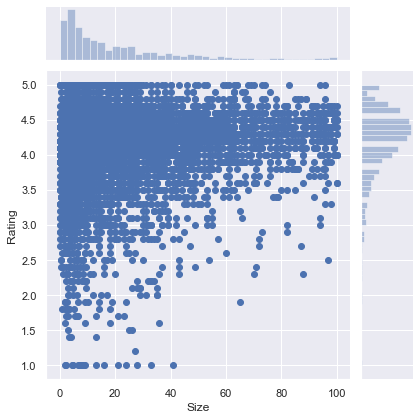

In [12]:
grupos = df.groupby('Category').filter(lambda x: len(x) >= 50).reset_index()
sns.set_style("darkgrid")
ax = sns.jointplot(df['Size'], df['Rating'])

- A maioria dos Apps mais bem avaliados se encontra na faixa entre ~2mb ~ 40mb

## Estratégia de preço: Pago ou gratuito?

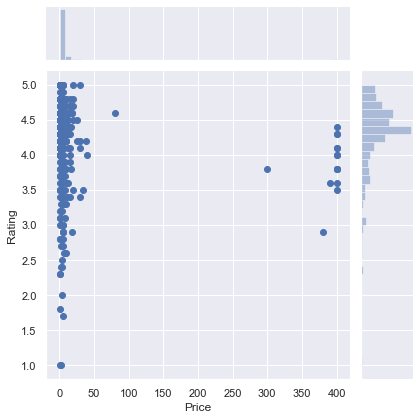

In [13]:
paid_apps = df[df.Price>0]
p = sns.jointplot( "Price", "Rating", paid_apps)

- A maioria dos mais bem avaliados Apps pagos se encontram na faixa de 1 ~ 30

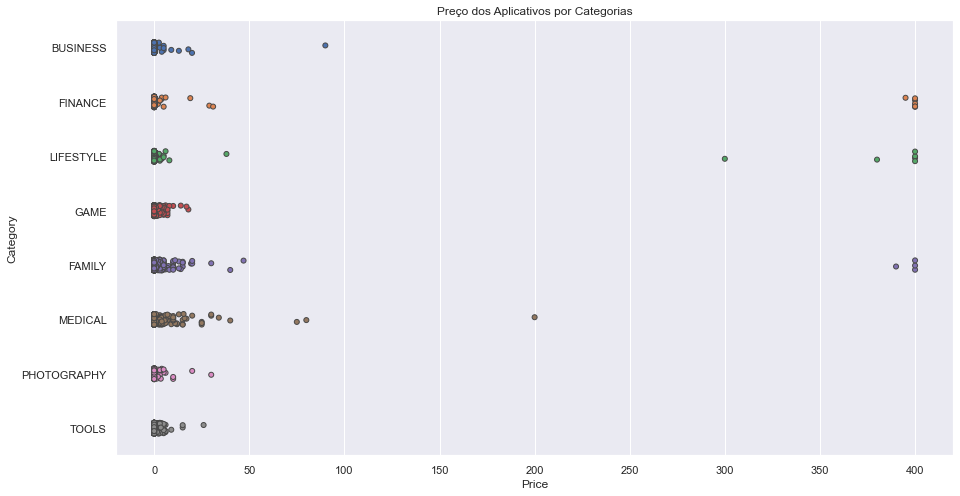

In [17]:
subset_df = df[df.Category.isin(['GAME', 'FAMILY', 'PHOTOGRAPHY', 'MEDICAL', 'TOOLS', 'FINANCE',
                                 'LIFESTYLE','BUSINESS'])]
sns.set_style('darkgrid')
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
p = sns.stripplot(x="Price", y="Category", data=subset_df, jitter=True, linewidth=1)
title = ax.set_title('Preço dos Aplicativos por Categorias')

- Os aplicativos relacionados com as categorias 'Medical' e 'Family' se mostraram os mais caros, chegando a 80
- Aplicativos acima de 200 são outliers
- Todos os apps da categoria 'Game' estão abaixo dos $20

## Distribuição de Apps pagos e gratuitos por categoria

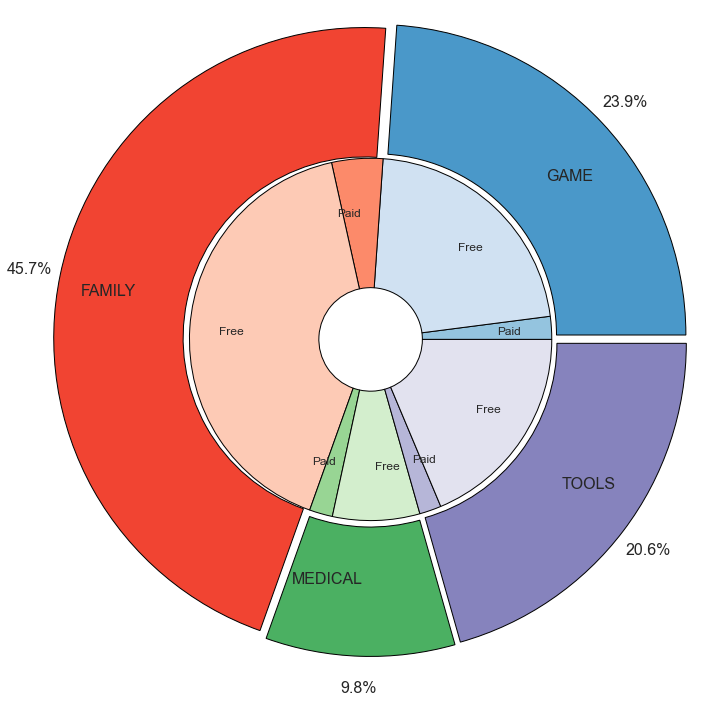

In [22]:

new_df = df.groupby(['Category', 'Type']).agg({'App' : 'count'}).reset_index()


outer_group_names = ['GAME', 'FAMILY', 'MEDICAL', 'TOOLS']
outer_group_values = [len(df.App[df.Category == category]) for category in outer_group_names]

a, b, c, d=[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens, plt.cm.Purples]


inner_group_names = ['Paid', 'Free'] * 4
inner_group_values = []
#inner_colors = ['#58a27c','#FFD433']


for category in outer_group_names:
    for t in ['Paid', 'Free']:
        x = new_df[new_df.Category == category]
        try:
            #print(x.App[x.Type == t].values[0])
            inner_group_values.append(int(x.App[x.Type == t].values[0]))
        except:
            #print(x.App[x.Type == t].values[0])
            inner_group_values.append(0)

explode = (0.025,0.025,0.025,0.025)
# First Ring (outside)
fig, ax = plt.subplots(figsize=(10,10))
ax.axis('equal')
mypie, texts, _ = ax.pie(outer_group_values, radius=1.2, labels=outer_group_names, autopct='%1.1f%%', pctdistance=1.1,
                                 labeldistance= 0.75,  explode = explode, colors=[a(0.6), b(0.6), c(0.6), d(0.6)], textprops={'fontsize': 16})
plt.setp( mypie, width=0.5, edgecolor='black')
 
# Second Ring (Inside)
mypie2, _ = ax.pie(inner_group_values, radius=1.2-0.5, labels=inner_group_names, labeldistance= 0.7, 
                   textprops={'fontsize': 12}, colors = [a(0.4), a(0.2), b(0.4), b(0.2), c(0.4), c(0.2), d(0.4), d(0.2)])
plt.setp( mypie2, width=0.5, edgecolor='black')
plt.margins(0,0)
 
# show it
plt.tight_layout()
plt.show()


## Relação entre número de downloads entre Apps pagos e gratuitos

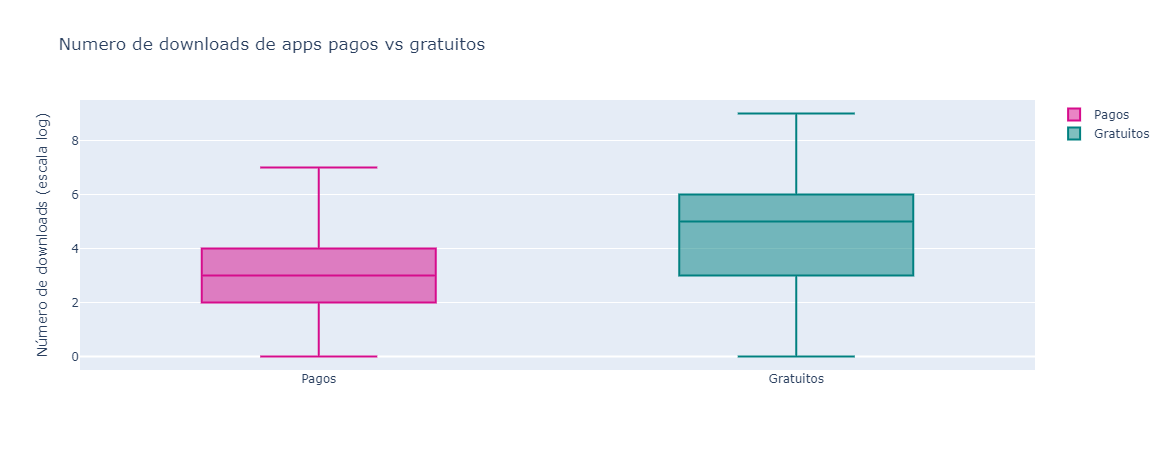

In [25]:
trace0 = go.Box(
    y=np.log10(df['Installs'][df.Type=='Paid']),
    name = 'Pagos',
    marker = dict(
        color = 'rgb(214, 12, 140)',
    )

)
trace1 = go.Box(
    y=np.log10(df['Installs'][df.Type=='Free']),
    name = 'Gratuitos',
    marker = dict(
        color = 'rgb(0, 128, 128)',
    )
)
layout = go.Layout(
    title = "Numero de downloads de apps pagos vs gratuitos",
    yaxis= {'title': 'Número de downloads (escala log)'}
)
data = [trace0, trace1]
plotly.offline.iplot({'data': data, 'layout': layout})

- Aplicativos gratuitos tiveram vantagem no número de downloads em relação aos pagos

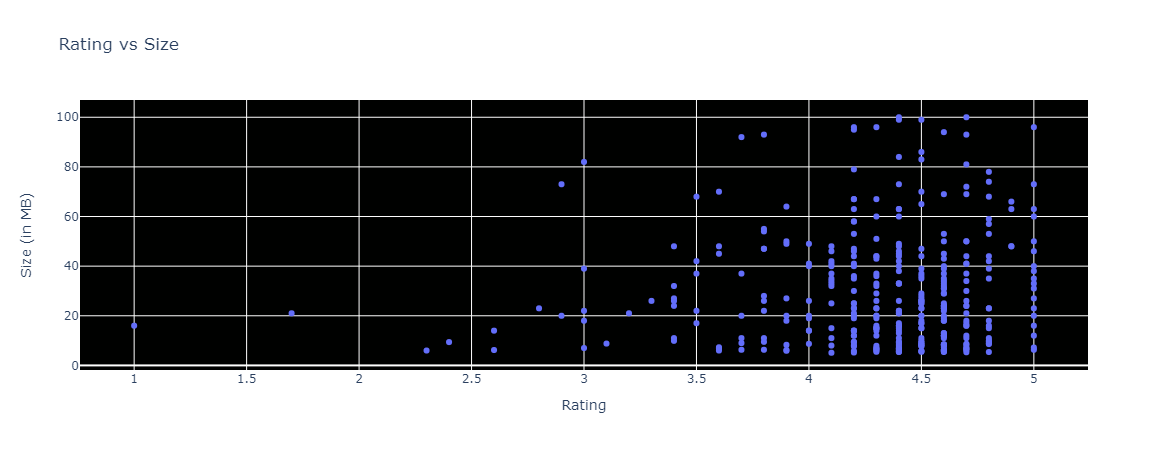

In [27]:
temp_df = df[df.Type == 'Paid']
temp_df = temp_df[temp_df.Size > 5]


data = [{
    'x' : temp_df['Rating'],
    'type':'scatter',
    'y' : temp_df['Size'],
    #'name' : t,
    'mode' : 'markers',
    #'showlegend': True,
    'text' : df['Size'],
    } for t in set(temp_df.Type)]


layout = {'title':"Rating vs Size", 
          'xaxis': {'title' : 'Rating'},
          'yaxis' : {'title' : 'Size (in MB)'},
         'plot_bgcolor': 'rgb(0,0,0)'}

plotly.offline.iplot({'data': data, 'layout': layout})

- A maioria dos Apps pagos mais bem avaliados foram feitos para serem leves, sendo provavelmente especificos para uma função

- Apps pagos e pesados tendem a não serem tão efetivos

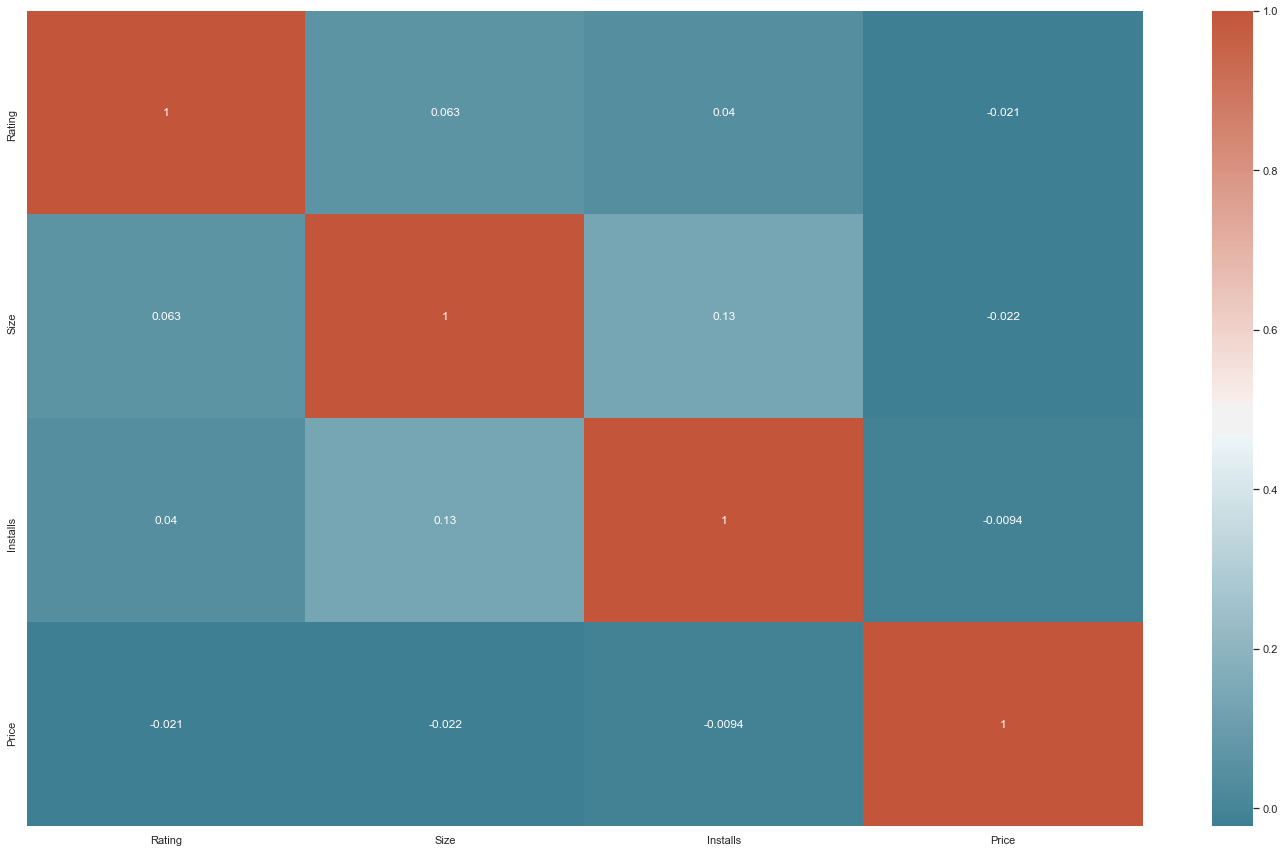

In [28]:
corrmat = df.corr()
#f, ax = plt.subplots()
p =sns.heatmap(corrmat, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

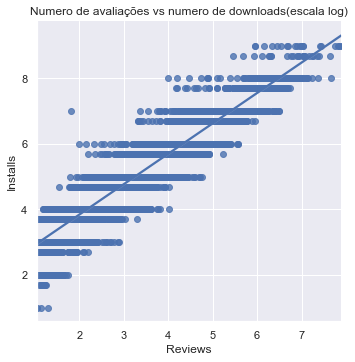

In [33]:
df_copy = df.copy()

df_copy = df_copy[df_copy.Reviews > 10]
df_copy = df_copy[df_copy.Installs > 0]

df_copy['Installs'] = np.log10(df['Installs'])
df_copy['Reviews'] = np.log10(df['Reviews'])

sns.lmplot("Reviews", "Installs", data=df_copy)
ax = plt.gca()
_ = ax.set_title('Numero de avaliações vs numero de downloads(escala log)')

- Existe uma correlação de 0.063 entre reviews e o número de downloads 
    - Isso significa que as pessoas tendem a baixar aplicativos que foram avaliados por um grande número de pessoas
    - Uma boa estratégia seria incentivar avaliações

# Conclusão

- O valor médio das avaliações na Google Play é 4.17
- Usuáris tendem a baixar aplicativos que foram avaliados por um grande número de pessoas
- Health and Fitness' e 'Books and Reference tiveram' um desempenho geral bem acima da média
- Usuários preferem pagar por aplicativos mais leves
- A maioria dos Apps mais bem avaliados se encontram no range de 2mb ~ 40mb
- A mairoira dos Apps pagos mais bem avaliados se encontram no range de preço de 1 ~ 30